In [1]:
import sys
import os

# 添加 src 到路径，便于导入
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "../src")))
print("当前工作目录:", os.getcwd())

当前工作目录: c:\Users\bimer\Desktop\CADNumberingAnnotationArrangement\tests


In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

In [3]:
import display_class
import json

from shapely.geometry import Point, Polygon, LineString, box
import math
import numpy as np
import re
from rich import print

# 自定义模块导入
from CADAlgo.check import *
from CADAlgo.generate import *
from CADAlgo.parser import *

In [4]:
with open("N02主视图.json", "r", encoding="utf-8") as f:
    data = json.load(f)

schema = parse_schema(data)
schema.schema_name = '_N02_front_view'

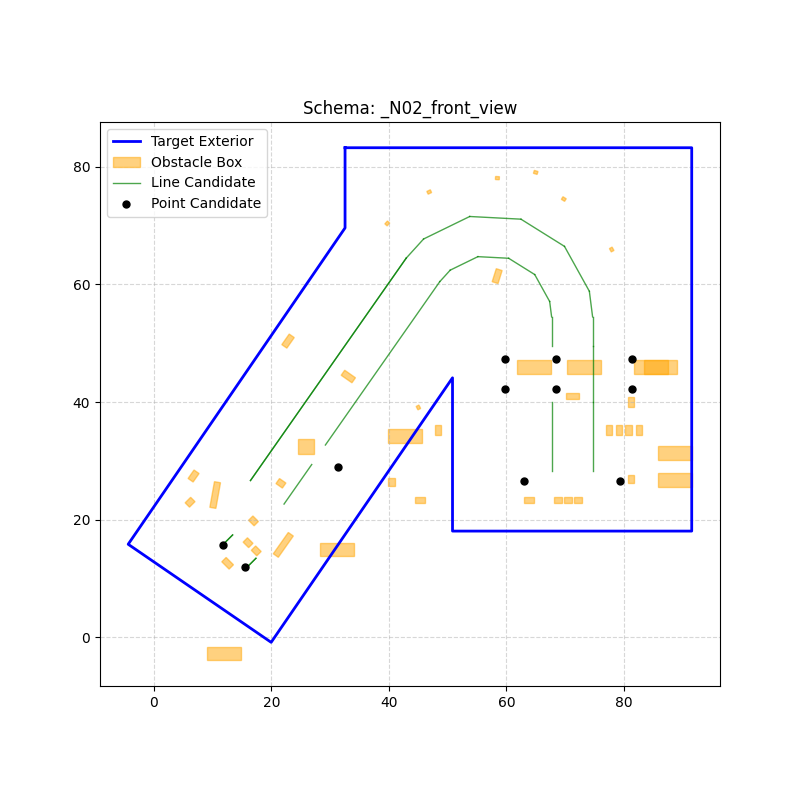

In [5]:
_, _ = display_class.plot_schema(schema)

In [6]:
candidates = schema.point_candidates
exterior = schema.target_exterior
obstacles = [obstacle_box.geometry for obstacle_box in schema.obstacle_boxes]
samples_distance = 5
lines = generate_connection_lines_from_point_candidates(candidates, exterior, obstacles, samples_distance=samples_distance)


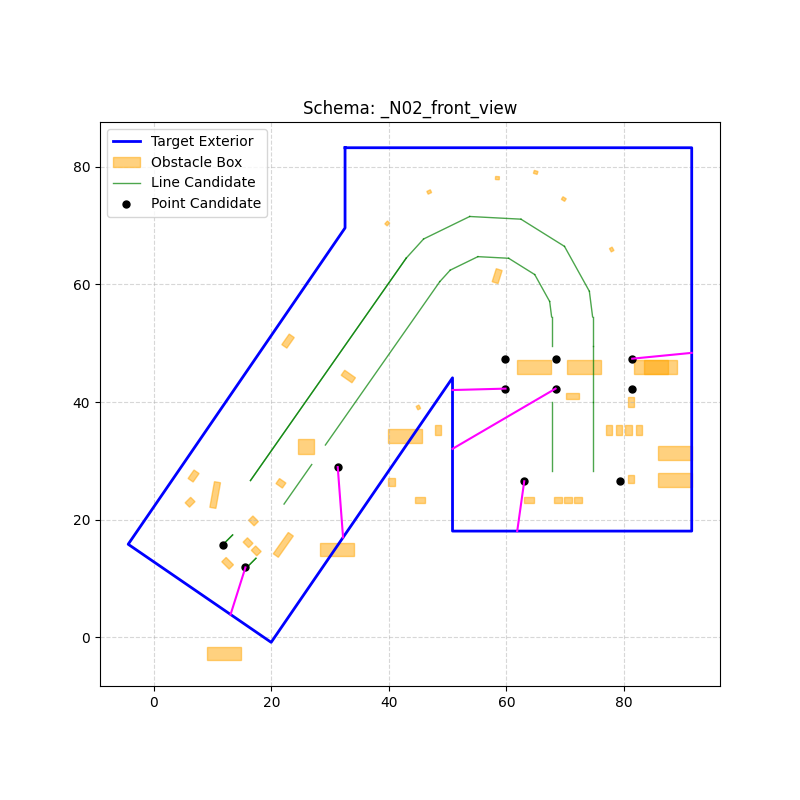

In [7]:
fig, ax = display_class.plot_schema(schema)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="magenta", linewidth=1.5)

**解析障碍物盒子**

In [8]:
with open("block_boxes.txt", "r", encoding="utf-8") as f:
    raw_data = f.read()

# 解析每一行
obstacle_boxes = []

for line in raw_data.splitlines():
    # 找出每行的四个坐标点
    matches = re.findall(r"\(([\d.]+),\s*([\d.]+)\)", line)
    if len(matches) != 4:
        raise Exception("没有四个!")

    # 转为 float
    points = [(float(x), float(y)) for x, y in matches]

    # 构造 box 对象
    box = {
        "a": {"x": points[0][0], "y": points[0][1]},
        "b": {"x": points[1][0], "y": points[1][1]},
        "c": {"x": points[2][0], "y": points[2][1]},
        "d": {"x": points[3][0], "y": points[3][1]},
    }

    obstacle_boxes.append(box)

# 最终结果
block_boxes_result = {"obstacle_box": obstacle_boxes}
block_boxes_result_json = json.dumps(block_boxes_result, indent=2)
print(block_boxes_result)

{
    'obstacle_box': [
        {
            'a': {'x': 240.264920577956, 'y': 192.032402717687},
            'b': {'x': 240.9723367172, 'y': 190.161690979888},
            'c': {'x': 242.468906107439, 'y': 190.727623891283},
            'd': {'x': 241.761489968195, 'y': 192.598335629082}
        },
        {
            'a': {'x': 197.770477282181, 'y': 243.385550495482},
            'b': {'x': 199.677911183676, 'y': 242.784138896471},
            'c': {'x': 200.159040462885, 'y': 244.310086017668},
            'd': {'x': 198.251606561389, 'y': 244.911497616679}
        },
        {
            'a': {'x': 136.071376462819, 'y': 119.640281265068},
            'b': {'x': 136.994873689288, 'y': 117.866259598711},
            'c': {'x': 138.414091022374, 'y': 118.605057379886},
            'd': {'x': 137.490593795904, 'y': 120.379079046243}
        },
        {
            'a': {'x': 63.0567183328408, 'y': 79.8908108784654},
            'b': {'x': 67.0693088239243, 'y': 77.0811647688602},
            'c': {'x': 68.8978705030115, 'y': 79.6926214860535},
            'd': {'x': 64.885280011928, 'y': 82.5022675956587}
        },
        {
            'a': {'x': 39.5035030478077, 'y': 34.900364629501},
            'b': {'x': 34.900364629501, 'y': 39.5035030478077},
            'c': {'x': 37.1546210479237, 'y': 41.7577594662304},
            'd': {'x': 41.7577594662304, 'y': 37.1546210479237}
        },
        {
            'a': {'x': 75.6305660473943, 'y': 147.077637880875},
            'b': {'x': 86.8528476827109, 'y': 163.106968814864},
            'c': {'x': 84.2412702740296, 'y': 164.935358116535},
            'd': {'x': 73.018988638713, 'y': 148.906027182546}
        },
        {
            'a': {'x': 73.2095542641575, 'y': 53.6156878328156},
            'b': {'x': 63.8068112567258, 'y': 40.2667486675204},
            'c': {'x': 61.2004758234082, 'y': 42.1026025857374},
            'd': {'x': 70.6032188308399, 'y': 55.4515417510327}
        },
        {
            'a': {'x': 31.9976622659518, 'y': 65.3902624991933},
            'b': {'x': 34.8867133008197, 'y': 81.4607054619896},
            'c': {'x': 31.7490134128811, 'y': 82.0247829506648},
            'd': {'x': 28.8599623780132, 'y': 65.9543399878686}
        },
        {
            'a': {'x': 48.5459032871388, 'y': 60.1618129620795},
            'b': {'x': 60.0915897739304, 'y': 48.6161264752879},
            'c': {'x': 62.3458461923531, 'y': 50.8703828937106},
            'd': {'x': 50.8001597055615, 'y': 62.4160693805022}
        },
        {
            'a': {'x': 251.895950923034, 'y': 118.802290532709},
            'b': {'x': 251.895950923034, 'y': 125.312111313359},
            'c': {'x': 248.707950923034, 'y': 125.312111313359},
            'd': {'x': 248.707950923034, 'y': 118.802290532709}
        },
        {
            'a': {'x': 70.8282099576849, 'y': 157.65246431926},
            'b': {'x': 66.1680025285479, 'y': 150.996998368333},
            'c': {'x': 63.5565458113546, 'y': 152.82556004742},
            'd': {'x': 68.2167532404916, 'y': 159.481025998347}
        },
        {
            'a': {'x': 21.3914308713196, 'y': 87.0494268073177},
            'b': {'x': 17.6575510666704, 'y': 81.7168938068933},
            'c': {'x': 15.0460943494771, 'y': 83.5454554859804},
            'd': {'x': 18.7799741541263, 'y': 88.8779884864048}
        },
        {
            'a': {'x': 19.5997368232912, 'y': 72.6981527895419},
            'b': {'x': 16.135996524831, 'y': 69.2344124910818},
            'c': {'x': 13.8817401064083, 'y': 71.4886689095045},
            'd': {'x': 17.3454804048684, 'y': 74.9524092079646}
        },
        {
            'a': {'x': 251.895950923034, 'y': 79.5929666697234},
            'b': {'x': 251.895950923034, 'y': 84.4914351763438},
            'c': {'x': 248.707950923034, 'y': 84.4914351763438},
            'd': {'x': 248.707950923034, 'y': 79.5929666697234}
        },
        {
            'a': {'x': 221.08820893349, 'y': 123.353450

**解析障碍物线**

In [9]:
import json
import re

barrier_lines = []

with open("block_lines.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # 跳过空行

        # 匹配一行中的两个点
        match = re.match(r"\(([^,]+),\s*([^)]+)\),\s*\(([^,]+),\s*([^)]+)\)", line)
        if match:
            x1, y1, x2, y2 = map(float, match.groups())
            barrier_lines.append({"x1": x1, "y1": y1, "x2": x2, "y2": y2})
        else:
            print(f"格式不匹配: {line}")

obstacle_box_result = {"barrier_line": barrier_lines}

# 输出 JSON 字符串，格式化缩进
obstacle_box_result_str = json.dumps(obstacle_box_result, indent=2, ensure_ascii=False)

print(obstacle_box_result_str)

{
  "barrier_line": [
    {
      "x1": 251.934405275878,
      "y1": 136.642200923034,
      "x2": 251.934405275878,
      "y2": -5.88109685879965
    },
    {
      "x1": 41.9422009230337,
      "y1": 41.9422009230336,
      "x2": 41.9422009230337,
      "y2": -5.88109685879965
    },
    {
      "x1": 96.19483641302,
      "y1": 84.1268149585684,
      "x2": 96.19483641302,
      "y2": 78.0422009230337
    },
    {
      "x1": 212.271678061245,
      "y1": 136.642200923034,
      "x2": 212.271678061245,
      "y2": 78.0422009230337
    },
    {
      "x1": 222.518405475658,
      "y1": 136.642200923034,
      "x2": 222.518405475658,
      "y2": 78.0422009230337
    },
    {
      "x1": 181.950317342619,
      "y1": 136.642200923034,
      "x2": 181.950317342619,
      "y2": 78.0422009230337
    },
    {
      "x1": 21.9422009230338,
      "y1": -5.88109685879965,
      "x2": 271.934405275878,
      "y2": -5.88109685879965
    },
    {
      "x1": 47.931184496872,
      "y1": 78.0422009230337,
      "x2": 271.934405275878,
      "y2": 78.0422009230337
    }
  ]
}

In [10]:
points = []

with open("box_edges.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        # 匹配 (x, y)
        match = re.match(r"\(([^,]+),\s*([^)]+)\)", line)
        if match:
            x_str, y_str = match.groups()
            point = {
                "x": float(x_str),
                "y": float(y_str)
            }
            points.append(point)
        else:
            print(f"格式不匹配: {line}")

# 生成目标结构
exterior_result_dict = {"target_exterior": points}

# 输出为格式化 JSON 字符串
json_str = json.dumps(exterior_result_dict, indent=2, ensure_ascii=False)
print(exterior_result_dict)


{
    'target_exterior': [
        {'x': 99.2123999999999, 'y': 253.77648},
        {'x': 99.2123999999999, 'y': 212.20176},
        {'x': -13.22832, 'y': 48.18888},
        {'x': 60.89904, 'y': -2.65176000000001},
        {'x': 154.92984, 'y': 134.47776},
        {'x': 154.92984, 'y': 55.0164},
        {'x': 278.95296, 'y': 55.0164},
        {'x': 278.95296, 'y': 253.77648}
    ]
}

In [11]:
with open("parts.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

lines = raw_text.strip().splitlines()
part_data = {
    "line_candidates": [],
    "point_candidates": []
}

i = 0
while i < len(lines):
    header_match = re.match(r"(\d+)\s+(\d+)\s+(\d+)", lines[i])
    if not header_match:
        i += 1
        continue

    part_index, point_count, line_count = map(int, header_match.groups())
    part_name = f"零件{part_index}"
    i += 1

    if point_count > 0:
        points = []
        for _ in range(point_count):
            point_match = re.findall(r"\(([^)]+)\)", lines[i])
            if point_match:
                x, y = map(float, point_match[0].split(','))
                points.append({"x": x, "y": y})
            i += 1
        part_data["point_candidates"].append({
            "part_name": part_name,
            "points": points
        })

    elif line_count > 0:
        lines_list = []
        for _ in range(line_count):
            line_match = re.findall(r"\(([^)]+)\)", lines[i])
            if len(line_match) == 2:
                x1, y1 = map(float, line_match[0].split(','))
                x2, y2 = map(float, line_match[1].split(','))
                lines_list.append({
                    "x1": x1, "y1": y1,
                    "x2": x2, "y2": y2
                })
            i += 1
        part_data["line_candidates"].append({
            "part_name": part_name,
            "lines": lines_list
        })

# 构建最终 JSON 结构
part_output_dict = {"part": part_data}

# 显示为字符串（可选：保存为文件）
print(json.dumps(part_output_dict, indent=2, ensure_ascii=False))

# 可保存为文件：
# with open("parsed_parts.json", "w", encoding="utf-8") as f:
#     json.dump(output_json, f, ensure_ascii=False, indent=2)


{
  "part": {
    "line_candidates": [
      {
        "part_name": "零件1",
        "lines": [
          {
            "x1": 206.317200923034,
            "y1": 122.122200923034,
            "x2": 206.317200923034,
            "y2": 110.095534256367
          },
          {
            "x1": 206.317200923034,
            "y1": 156.132200923034,
            "x2": 206.317200923034,
            "y2": 151.162200923034
          },
          {
            "x1": 206.317200923034,
            "y1": 110.095534256367,
            "x2": 206.317200923034,
            "y2": 98.0688675897002
          },
          {
            "x1": 206.317200923034,
            "y1": 161.102200923034,
            "x2": 206.317200923034,
            "y2": 156.132200923034
          },
          {
            "x1": 206.317200923034,
            "y1": 166.072200923034,
            "x2": 206.317200923034,
            "y2": 161.102200923034
          },
          {
            "x1": 206.317200923034,
            "y1": 98.0688675897002,
            "x2": 206.317200923034,
            "y2": 86.0422009230335
          },
          {
            "x1": 227.567200923034,
            "y1": 122.122200923034,
            "x2": 227.567200923034,
            "y2": 110.095534256367
          },
          {
            "x1": 227.567200923034,
            "y1": 156.132200923034,
            "x2": 227.567200923034,
            "y2": 151.162200923034
          },
          {
            "x1": 227.567200923034,
            "y1": 110.095534256367,
            "x2": 227.567200923034,
            "y2": 98.0688675897002
          },
          {
            "x1": 227.567200923034,
            "y1": 161.102200923034,
            "x2": 227.567200923034,
            "y2": 156.132200923034
          },
          {
            "x1": 227.567200923034,
            "y1": 166.072200923034,
            "x2": 227.567200923034,
            "y2": 161.102200923034
          },
          {
            "x1": 227.567200923034,
            "y1": 98.0688675897002,
            "x2": 227.567200923034,
            "y2": 86.0422009230335
          }
        ]
      },
      {
        "part_name": "零件2",
        "lines": [
          {
            "x1": 190.417196521699,
            "y1": 216.738413931533,
            "x2": 184.099283818985,
            "y2": 217.530151111307
          },
          {
            "x1": 196.046649417867,
            "y1": 213.763161207685,
            "x2": 190.417196521699,
            "y2": 216.738413931533
          },
          {
            "x1": 184.099283818985,
            "y1": 217.530151111307,
            "x2": 177.781371116272,
            "y2": 218.321888291081
          },
          {
            "x1": 201.676102314035,
            "y1": 210.787908483837,
            "x2": 196.046649417867,
            "y2": 213.763161207685
          },
          {
            "x1": 177.781371116272,
            "y1": 218.321888291081,
            "x2": 171.463458413558,
            "y2": 219.113625470855
          },
          {
            "x1": 207.305555210204,
            "y1": 207.812655759989,
            "x2": 201.676102314035,
            "y2": 210.787908483837
          },
          {
            "x1": 171.463458413558,
            "y1": 219.113625470855,
            "x2": 165.273917858377,
            "y2": 217.619484782461
          },
          {
            "x1": 211.518726117734,
            "y1": 203.038552746345,
            "x2": 207.305555210204,
            "y2": 207.812655759989
          },
          {
            "x1": 165.273917858377,
            "y1": 217.619484782461,
            "x2": 159.084377303196,
            "y2": 216.125344094068
          },
          {
            "x1": 215.731897025265,
            "y1": 198.264449732701,
            "x2": 211.518726117734,
            "y2": 203.038552746345
          },
          {
            "x1": 159.084377303196,
            "y1": 216.125344094068,
            "x2": 152.894836748015,
            "y2":

In [12]:
final_result_dict = {
  "schema_name":"_N02_front_view",**block_boxes_result, **obstacle_box_result, **exterior_result_dict, **part_output_dict
}
print(final_result_dict)

{
    'schema_name': '_N02_front_view',
    'obstacle_box': [
        {
            'a': {'x': 240.264920577956, 'y': 192.032402717687},
            'b': {'x': 240.9723367172, 'y': 190.161690979888},
            'c': {'x': 242.468906107439, 'y': 190.727623891283},
            'd': {'x': 241.761489968195, 'y': 192.598335629082}
        },
        {
            'a': {'x': 197.770477282181, 'y': 243.385550495482},
            'b': {'x': 199.677911183676, 'y': 242.784138896471},
            'c': {'x': 200.159040462885, 'y': 244.310086017668},
            'd': {'x': 198.251606561389, 'y': 244.911497616679}
        },
        {
            'a': {'x': 136.071376462819, 'y': 119.640281265068},
            'b': {'x': 136.994873689288, 'y': 117.866259598711},
            'c': {'x': 138.414091022374, 'y': 118.605057379886},
            'd': {'x': 137.490593795904, 'y': 120.379079046243}
        },
        {
            'a': {'x': 63.0567183328408, 'y': 79.8908108784654},
            'b': {'x': 67.0693088239243, 'y': 77.0811647688602},
            'c': {'x': 68.8978705030115, 'y': 79.6926214860535},
            'd': {'x': 64.885280011928, 'y': 82.5022675956587}
        },
        {
            'a': {'x': 39.5035030478077, 'y': 34.900364629501},
            'b': {'x': 34.900364629501, 'y': 39.5035030478077},
            'c': {'x': 37.1546210479237, 'y': 41.7577594662304},
            'd': {'x': 41.7577594662304, 'y': 37.1546210479237}
        },
        {
            'a': {'x': 75.6305660473943, 'y': 147.077637880875},
            'b': {'x': 86.8528476827109, 'y': 163.106968814864},
            'c': {'x': 84.2412702740296, 'y': 164.935358116535},
            'd': {'x': 73.018988638713, 'y': 148.906027182546}
        },
        {
            'a': {'x': 73.2095542641575, 'y': 53.6156878328156},
            'b': {'x': 63.8068112567258, 'y': 40.2667486675204},
            'c': {'x': 61.2004758234082, 'y': 42.1026025857374},
            'd': {'x': 70.6032188308399, 'y': 55.4515417510327}
        },
        {
            'a': {'x': 31.9976622659518, 'y': 65.3902624991933},
            'b': {'x': 34.8867133008197, 'y': 81.4607054619896},
            'c': {'x': 31.7490134128811, 'y': 82.0247829506648},
            'd': {'x': 28.8599623780132, 'y': 65.9543399878686}
        },
        {
            'a': {'x': 48.5459032871388, 'y': 60.1618129620795},
            'b': {'x': 60.0915897739304, 'y': 48.6161264752879},
            'c': {'x': 62.3458461923531, 'y': 50.8703828937106},
            'd': {'x': 50.8001597055615, 'y': 62.4160693805022}
        },
        {
            'a': {'x': 251.895950923034, 'y': 118.802290532709},
            'b': {'x': 251.895950923034, 'y': 125.312111313359},
            'c': {'x': 248.707950923034, 'y': 125.312111313359},
            'd': {'x': 248.707950923034, 'y': 118.802290532709}
        },
        {
            'a': {'x': 70.8282099576849, 'y': 157.65246431926},
            'b': {'x': 66.1680025285479, 'y': 150.996998368333},
            'c': {'x': 63.5565458113546, 'y': 152.82556004742},
            'd': {'x': 68.2167532404916, 'y': 159.481025998347}
        },
        {
            'a': {'x': 21.3914308713196, 'y': 87.0494268073177},
            'b': {'x': 17.6575510666704, 'y': 81.7168938068933},
            'c': {'x': 15.0460943494771, 'y': 83.5454554859804},
            'd': {'x': 18.7799741541263, 'y': 88.8779884864048}
        },
        {
            'a': {'x': 19.5997368232912, 'y': 72.6981527895419},
            'b': {'x': 16.135996524831, 'y': 69.2344124910818},
            'c': {'x': 13.8817401064083, 'y': 71.4886689095045},
            'd': {'x': 17.3454804048684, 'y': 74.9524092079646}
        },
        {
            'a': {'x': 251.895950923034, 'y': 79.5929666697234},
            'b': {'x': 251.895950923034, 'y': 84.4914351763438},
            'c': {'x': 248.707950923034, 'y': 84.4914351763438},
            'd': {'x': 248.707950923034, 'y': 79.5929666697234}
        },
        {
            'a': 

In [13]:
with open("result.json", "w", encoding="utf-8") as f:
  json.dump(final_result_dict, f, ensure_ascii=False, indent=2)


In [14]:
schema= parse_schema(final_result_dict)

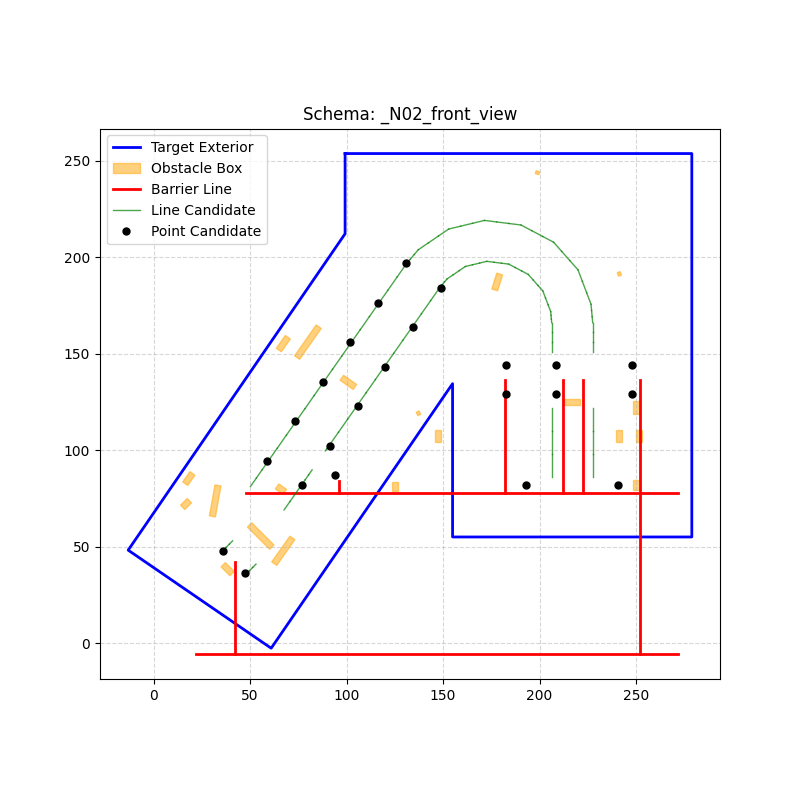

In [15]:
_, _ = display_class.plot_schema(schema)

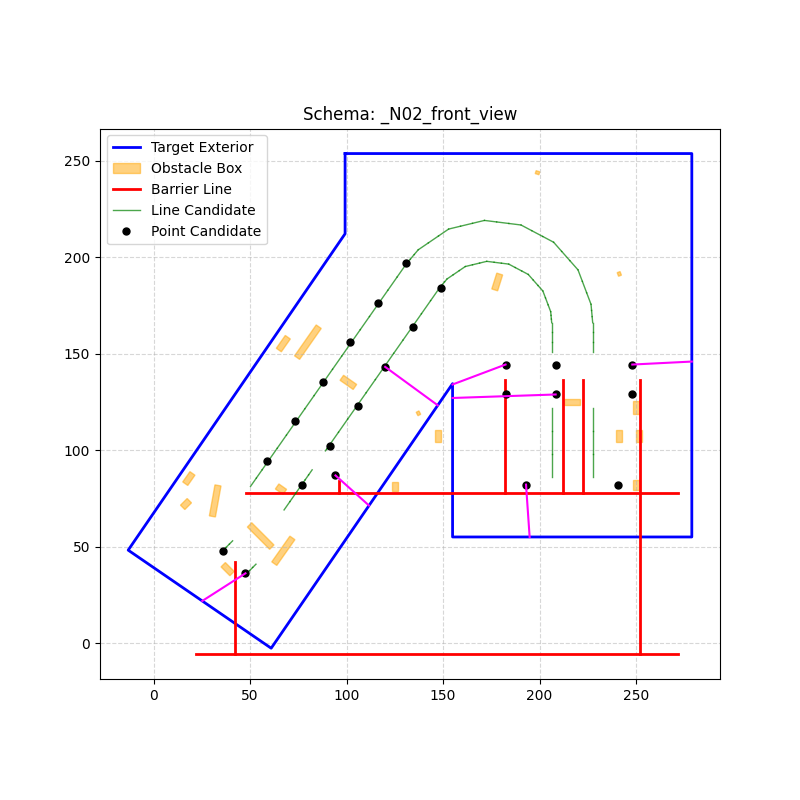

In [16]:
candidates = schema.point_candidates
exterior = schema.target_exterior
obstacles = [obstacle_box.geometry for obstacle_box in schema.obstacle_boxes]
samples_distance = 7
lines = generate_connection_lines_from_point_candidates(candidates, exterior, obstacles, samples_distance=samples_distance)

fig, ax = display_class.plot_schema(schema)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="magenta", linewidth=1.5)